In [69]:
import os
import pandas as pd
import yfinance as yf
import joblib
from tools.machinelearning import get_enriched_stock_data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

watchlist = pd.read_csv("watchlist.csv")
symbols = watchlist['ticker'].tolist()

results = []

for ticker in symbols:
    try:
        df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
        if df.empty:
            print(f"Keine Daten für {ticker}, überspringe.")
            continue
        
        df_inference = get_enriched_stock_data(ticker, change=0, inference=True, df=df)
        df_long = get_enriched_stock_data(ticker, change=0.2, change_next_days=20, df=df)
        df_short = get_enriched_stock_data(ticker, change=0.15, change_next_days=20, df=df)

        y_long = df_long["change"]
        X_long = df_long.drop(columns=["change", "Ticker", "Date"], errors='ignore')

        y_short = df_short["change"]
        X_short = df_short.drop(columns=["change", "Ticker", "Date"], errors='ignore')

        # Dateipfade für Modelle
        long_model_path = os.path.join(model_dir, f"{ticker}_long_model.pkl")
        short_model_path = os.path.join(model_dir, f"{ticker}_short_model.pkl")

        # Long Modell laden oder trainieren
        if os.path.exists(long_model_path):
            best_model_long = joblib.load(long_model_path)
            print(f"Long Modell für {ticker} geladen.")
        else:
            model = RandomForestClassifier(random_state=42)
            param_grid = {
                "n_estimators": [50, 100],
                "max_depth": [5, 10, None],
                "min_samples_split": [2, 5],
                "min_samples_leaf": [1, 2]
            }
            tscv = TimeSeriesSplit(n_splits=5)
            grid_long = GridSearchCV(model, param_grid, cv=tscv, scoring='precision', n_jobs=-1)
            grid_long.fit(X_long, y_long)
            best_model_long = grid_long.best_estimator_
            joblib.dump(best_model_long, long_model_path)
            print(f"Long Modell für {ticker} trainiert und gespeichert.")

        # Short Modell laden oder trainieren
        if os.path.exists(short_model_path):
            best_model_short = joblib.load(short_model_path)
            print(f"Short Modell für {ticker} geladen.")
        else:
            model = RandomForestClassifier(random_state=42)
            param_grid = {
                "n_estimators": [50, 100],
                "max_depth": [5, 10, None],
                "min_samples_split": [2, 5],
                "min_samples_leaf": [1, 2]
            }
            tscv = TimeSeriesSplit(n_splits=5)
            grid_short = GridSearchCV(model, param_grid, cv=tscv, scoring='precision', n_jobs=-1)
            grid_short.fit(X_short, y_short)
            best_model_short = grid_short.best_estimator_
            joblib.dump(best_model_short, short_model_path)
            print(f"Short Modell für {ticker} trainiert und gespeichert.")

        # Datumsspalte für Inferenz
        df_inference['Date'] = pd.to_datetime(dict(year=df_inference.year,
                                                  month=df_inference.month,
                                                  day=df_inference.dayofmonth))

        X_inf = df_inference[X_long.columns]
        dates = df_inference["Date"].reset_index(drop=True)

        y_pred_long = best_model_long.predict(X_inf)
        last_long_idx = (pd.Series(y_pred_long[::-1]) == 1).idxmax() if 1 in y_pred_long else None
        last_long_date = dates.iloc[-(last_long_idx + 1)] if last_long_idx is not None else None

        y_pred_short = best_model_short.predict(X_inf)
        last_short_idx = (pd.Series(y_pred_short[::-1]) == 1).idxmax() if 1 in y_pred_short else None
        last_short_date = dates.iloc[-(last_short_idx + 1)] if last_short_idx is not None else None

        results.append({
            "Ticker": ticker,
            "Last Long Signal": last_long_date,
            "Last Short Signal": last_short_date
        })

    except Exception as e:
        print(f"Fehler bei {ticker}: {e}")

signals_df = pd.DataFrame(results)
print(signals_df)


C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_19032\1304998963.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
c:\Projekt\marketscreener\tools\machinelearning.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] = (df['change_raw'] > change).astype(int)
c:\Projekt\marketscreener\tools\machinelearning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['change_raw'], inplace=True)
c:\Projekt\marketscre

Long Modell für NOV trainiert und gespeichert.
Short Modell für NOV trainiert und gespeichert.


C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_19032\1304998963.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
c:\Projekt\marketscreener\tools\machinelearning.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] = (df['change_raw'] > change).astype(int)
c:\Projekt\marketscreener\tools\machinelearning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['change_raw'], inplace=True)
c:\Projekt\marketscre

Long Modell für QBTS trainiert und gespeichert.
Short Modell für QBTS trainiert und gespeichert.


C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_19032\1304998963.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
c:\Projekt\marketscreener\tools\machinelearning.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] = (df['change_raw'] > change).astype(int)
c:\Projekt\marketscreener\tools\machinelearning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['change_raw'], inplace=True)
c:\Projekt\marketscre

Long Modell für AAPL trainiert und gespeichert.


c:\Projekt\marketscreener\investing_env\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_19032\1304998963.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
c:\Projekt\marketscreener\tools\machinelearning.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] = (df['change_raw'] > change).astype(int)
c:\Projekt\marketscreener\tools\machinelearning.py:28: SettingWithCopyWarning: 


Short Modell für AAPL trainiert und gespeichert.
Long Modell für NVDA trainiert und gespeichert.
Short Modell für NVDA trainiert und gespeichert.


C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_19032\1304998963.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
c:\Projekt\marketscreener\tools\machinelearning.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] = (df['change_raw'] > change).astype(int)
c:\Projekt\marketscreener\tools\machinelearning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['change_raw'], inplace=True)
c:\Projekt\marketscre

Long Modell für BYD trainiert und gespeichert.


c:\Projekt\marketscreener\investing_env\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_19032\1304998963.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
c:\Projekt\marketscreener\tools\machinelearning.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] = (df['change_raw'] > change).astype(int)
c:\Projekt\marketscreener\tools\machinelearning.py:28: SettingWithCopyWarning: 


Short Modell für BYD trainiert und gespeichert.


c:\Projekt\marketscreener\tools\machinelearning.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] = (df['change_raw'] > change).astype(int)
c:\Projekt\marketscreener\tools\machinelearning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['change_raw'], inplace=True)
c:\Projekt\marketscreener\tools\machinelearning.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Long Modell für DNA trainiert und gespeichert.
Short Modell für DNA trainiert und gespeichert.


C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_19032\1304998963.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
c:\Projekt\marketscreener\tools\machinelearning.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] = (df['change_raw'] > change).astype(int)
c:\Projekt\marketscreener\tools\machinelearning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['change_raw'], inplace=True)
c:\Projekt\marketscre

Long Modell für HYSR trainiert und gespeichert.
Short Modell für HYSR trainiert und gespeichert.


C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_19032\1304998963.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
c:\Projekt\marketscreener\tools\machinelearning.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] = (df['change_raw'] > change).astype(int)
c:\Projekt\marketscreener\tools\machinelearning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['change_raw'], inplace=True)
c:\Projekt\marketscre

Long Modell für LODE trainiert und gespeichert.
Short Modell für LODE trainiert und gespeichert.


C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_19032\1304998963.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
c:\Projekt\marketscreener\tools\machinelearning.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] = (df['change_raw'] > change).astype(int)
c:\Projekt\marketscreener\tools\machinelearning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['change_raw'], inplace=True)
c:\Projekt\marketscre

Long Modell für BAYRY trainiert und gespeichert.


c:\Projekt\marketscreener\investing_env\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_19032\1304998963.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)

1 Failed download:
['BAYERCROP']: YFTzMissingError('possibly delisted; no timezone found')


Short Modell für BAYRY trainiert und gespeichert.
Keine Daten für BAYERCROP, überspringe.
  Ticker Last Long Signal Last Short Signal
0    NOV       2023-07-06        2024-03-08
1   QBTS       2025-05-14        2025-05-19
2   AAPL       2024-06-10        2024-06-10
3   NVDA       2025-05-09        2025-05-30
4    BYD              NaT        2025-04-21
5    DNA       2025-06-04        2025-06-04
6   HYSR       2025-06-06        2025-06-09
7   LODE       2025-07-03        2025-07-03
8  BAYRY       2025-05-16        2025-05-20


In [66]:
import pandas as pd
import yfinance as yf
from tools.machinelearning import get_enriched_stock_data

watchlist = pd.read_csv("watchlist.csv")
symbols = watchlist['ticker'].tolist()

dfs_inference = []
dfs_long = []
dfs_short = []

for ticker in symbols:
    try:
        df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
        if df.empty:
            print(f"Keine Daten für {ticker}, überspringe.")
            continue
        
        df_inference = get_enriched_stock_data(ticker, change=0, inference=True, df=df)
        df_long = get_enriched_stock_data(ticker, change=0.2, change_next_days=20, df=df)
        df_short = get_enriched_stock_data(ticker, change=0.15, change_next_days=20, df=df)

        dfs_inference.append(df_inference)
        dfs_long.append(df_long)
        dfs_short.append(df_short)

    except Exception as e:
        print(f"Fehler bei {ticker}: {e}")

# Alle DataFrames zusammenfügen
df_inference_all = pd.concat(dfs_inference, ignore_index=True)
df_long_all = pd.concat(dfs_long, ignore_index=True)
df_short_all = pd.concat(dfs_short, ignore_index=True)


C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_19032\2695377509.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
c:\Projekt\marketscreener\tools\machinelearning.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] = (df['change_raw'] > change).astype(int)
c:\Projekt\marketscreener\tools\machinelearning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['change_raw'], inplace=True)
c:\Projekt\marketscre

Keine Daten für BAYERCROP, überspringe.


In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd

# Vorbereitung der Features und Labels für Long Modell
y_long = df_long["change"]
X_long = df_long.drop(columns=["change", "Ticker", "Date"], errors='ignore')

# Vorbereitung der Features und Labels für Short Modell
y_short = df_short["change"]
X_short = df_short.drop(columns=["change", "Ticker", "Date"], errors='ignore')


# Modelltraining Long
model = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
tscv = TimeSeriesSplit(n_splits=5)
grid_long = GridSearchCV(model, param_grid, cv=tscv, scoring='precision', n_jobs=-1)
grid_long.fit(X_long, y_long)
best_model_long = grid_long.best_estimator_
y_pred_long = best_model_long.predict(X_long)

# Modelltraining Short
grid_short = GridSearchCV(model, param_grid, cv=tscv, scoring='precision', n_jobs=-1)
grid_short.fit(X_short, y_short)
best_model_short = grid_short.best_estimator_
y_pred_short = best_model_short.predict(X_short)



df_inference_all['Date'] = pd.to_datetime(dict(year=df_inference_all.year,
                                              month=df_inference_all.month,
                                              day=df_inference_all.dayofmonth))

tickers = df_inference_all["Ticker"].unique()
results = []

for ticker in tickers:
    df_ticker = df_inference_all[df_inference_all["Ticker"] == ticker].copy()
    if df_ticker.empty:
        continue

    X_inf = df_ticker[X_long.columns]
    dates = df_ticker["Date"].reset_index(drop=True)

    # Long-Inferenz
    y_pred_long = best_model_long.predict(X_inf)
    last_long_idx = (pd.Series(y_pred_long[::-1]) == 1).idxmax() if 1 in y_pred_long else None
    last_long_date = dates.iloc[-(last_long_idx + 1)] if last_long_idx is not None else None

    # Short-Inferenz
    y_pred_short = best_model_short.predict(X_inf)
    last_short_idx = (pd.Series(y_pred_short[::-1]) == 1).idxmax() if 1 in y_pred_short else None
    last_short_date = dates.iloc[-(last_short_idx + 1)] if last_short_idx is not None else None

    results.append({
        "Ticker": ticker,
        "Last Long Signal": last_long_date,
        "Last Short Signal": last_short_date
    })

signals_df = pd.DataFrame(results)
print(signals_df)

c:\Projekt\marketscreener\investing_env\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


  Ticker Last Long Signal Last Short Signal
0    NOV              NaT               NaT
1   QBTS              NaT        2025-03-04
2   AAPL              NaT               NaT
3   NVDA              NaT               NaT
4    BYD              NaT               NaT
5    DNA              NaT               NaT
6   HYSR              NaT        2025-07-03
7   LODE              NaT        2025-07-03
8  BAYRY       2025-05-16        2025-05-20


c:\Projekt\marketscreener\investing_env\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


  Ticker Last Long Signal Last Short Signal
0    NOV             None               NaT
1   QBTS             None        2023-08-31
2   AAPL             None               NaT
3   NVDA             None               NaT
4    BYD             None               NaT
5    DNA             None               NaT
6   HYSR             None        2024-12-31
7   LODE             None        2025-02-28
8  BAYRY             None        2024-12-31


In [35]:
df_inference.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'KalmanClose', 'Open_HA',
       'High_HA', 'Low_HA', 'Close_HA', 'Volume_HA', 'MACD', 'MACD_Signal',
       'MACD_Hist', 'RSI', 't-1', 't-2', 't-3', 't-4', 't-5', 'mean_t5',
       'EMA_12', 'EMA_26', 'MACD_signal', 'gaussian', 'hour', 'dayofweek',
       'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'Ticker'],
      dtype='object')

In [3]:
from tools.machinelearning import get_enriched_stock_data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

y = combined_df["change"]
X = combined_df.drop(columns=["change", "Ticker", "Date"], errors='ignore')
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)



In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score

# Define model and parameter grid
model = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [50, 1000],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search
grid = GridSearchCV(model, param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
grid.fit(X, y)

# Best model and evaluation
best_model = grid.best_estimator_
y_pred = best_model.predict(X)
accuracy = accuracy_score(y, y_pred)

print("Best Params:", grid.best_params_)
print("Accuracy:", accuracy)

Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.9900725689404934


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Feature names (use X.columns if X is a DataFrame)
try:
    feature_names = X.columns
except AttributeError:
    feature_names = [f"feature_{i}" for i in range(X.shape[1])]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


NameError: name 'best_model' is not defined

In [ ]:
from tools.machinelearning import get_enriched_stock_data
get_enriched_stock_data("QBTS", change=-0.2)

c:\Projekt\marketscreener\tools\machinelearning.py:112: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
c:\Projekt\marketscreener\tools\machinelearning.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] = (df['change_raw'] > change).astype(int)
c:\Projekt\marketscreener\tools\machinelearning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['change_raw'], inplace=True)
c:\Projekt\marketscreener\tools\mach

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'KalmanClose', 'Open_HA',
       'High_HA', 'Low_HA', 'Close_HA', 'Volume_HA', 'MACD', 'MACD_Signal',
       'MACD_Hist', 'RSI', 'change', 't-1', 't-2', 't-3', 't-4', 't-5',
       'mean_t5', 'EMA_12', 'EMA_26', 'MACD_signal', 'gaussian', 'hour',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
       'Ticker'],
      dtype='object')

In [65]:
from tools.machinelearning import get_enriched_stock_data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import precision_score, confusion_matrix

inerence_df = get_enriched_stock_data("QBTS", change=0, inference=True)
inerence_df = inerence_df.drop(columns=["Ticker", "Date"], errors='ignore')

long_df = get_enriched_stock_data("QBTS", change=0.5)
short_df = get_enriched_stock_data("QBTS", change=-0.2)

y_long = long_df["change"]
X_long = long_df.drop(columns=["change", "Ticker", "Date"], errors='ignore')

y_short = short_df["change"]
X_short = short_df.drop(columns=["change", "Ticker", "Date"], errors='ignore')

# Gemeinsamer Modell- und Grid-Setup
model = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
tscv = TimeSeriesSplit(n_splits=5)

# LONG-MODELL
print("Training LONG model (change=0.5)...")
grid_long = GridSearchCV(model, param_grid, cv=tscv, scoring='precision', n_jobs=-1)
grid_long.fit(X_long, y_long)
best_model_long = grid_long.best_estimator_
y_pred_long = best_model_long.predict(X_long)
print("Confusion Matrix (LONG):")
print(confusion_matrix(y_long, y_pred_long))

# SHORT-MODELL
print("\nTraining SHORT model (change=-0.3)...")
grid_short = GridSearchCV(model, param_grid, cv=tscv, scoring='precision', n_jobs=-1)
grid_short.fit(X_short, y_short)
best_model_short = grid_short.best_estimator_
y_pred_short = best_model_short.predict(X_short)
print("Confusion Matrix (SHORT):")
print(confusion_matrix(y_short, y_pred_short))


c:\Projekt\marketscreener\tools\machinelearning.py:113: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
c:\Projekt\marketscreener\tools\machinelearning.py:113: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)
c:\Projekt\marketscreener\tools\machinelearning.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] = (df['change_raw'] > change).astype(int)
c:\Projekt\marketscreener\tools\machinelearning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Training LONG model (change=0.5)...
Confusion Matrix (LONG):
[[513   2]
 [ 23  53]]

Training SHORT model (change=-0.3)...
Confusion Matrix (SHORT):
[[ 78   6]
 [  0 507]]


c:\Projekt\marketscreener\tools\machinelearning.py:112: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-07-05", interval='1d', progress=False)


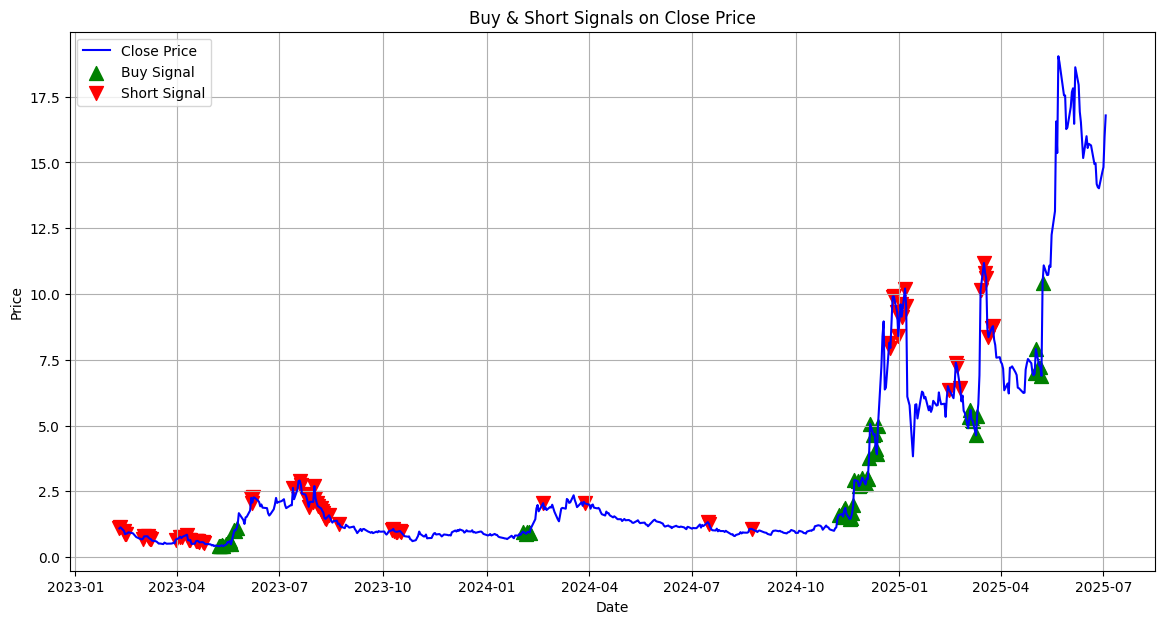

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Original Inferenzdaten mit Datum und Close neu laden
df_plot = get_enriched_stock_data("QBTS", change=0, inference=True).reset_index()

# Sicherstellen, dass Datum korrekt ist
if not np.issubdtype(df_plot['Date'].dtype, np.datetime64):
    df_plot['Date'] = pd.to_datetime(df_plot['Date'])

# Modellvorhersagen auf vorbereitetem inference_df
y_pred_long = best_model_long.predict(inerence_df)
y_pred_short = best_model_short.predict(inerence_df)

# Buy-Signale (Label == 0 im Long-Modell)
buy_signals = df_plot[y_pred_long == 1]

# Short-Signale (Label == 1 im Short-Modell)
short_signals = df_plot[y_pred_short == 0]

# Plot
plt.figure(figsize=(14, 7))
plt.plot(df_plot['Date'], df_plot['Close'], label='Close Price', color='blue')

# Buy-Signale als grüne Pfeile nach oben
plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)

# Short-Signale als rote Pfeile nach unten
plt.scatter(short_signals['Date'], short_signals['Close'], marker='v', color='red', label='Short Signal', s=100)

plt.title("Buy & Short Signals on Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
!pip install plotly

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.6 MB 1.1 MB/s eta 0:00:09
    --------------------------------------- 0.1/9.6 MB 1.4 MB/s eta 0:00:07
    --------------------------------------- 0.2/9.6 MB 1.6 MB/s eta 0:00:07
   - -------------------------------------- 0.3/9.6 MB 1.4 MB/s eta 0:00:07
   - -------------------------------------- 0.3/9.6 MB 1.4 MB/s eta 0:00:07
   - -------------------------------------- 0.3/9.6 MB 1.4 MB/s eta 0:00:07
   - -------------------------------------- 0.4/9.6 MB 1.4 MB/s eta 0:00:07
   -- ------------------------------------- 0.5/9.6 MB 1.5 MB/s eta 0:00:06
   -- ------------------------------------- 0.6/9.6 MB 1.6 MB/s eta 0:00:06
   -- ------------------------------------- 0.7/9.6 MB 1.6 MB/s eta 0:00:06
   --- ------------------------------------ 0.7/9.6 MB 1.6 MB/s eta 0:00:06
   --- -------------------


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import pandas as pd
import yfinance as yf
from tools.calculations import kalman_filter, heikin_ashi, calculate_macd, calculate_rsi

def create_ml_features(ticker):
    # 1. Download data
    df = yf.download(ticker, period="1mo", interval="1d", progress=False)

    if df.empty or "Close" not in df.columns:
        raise ValueError(f"No data found or invalid columns for ticker '{ticker}'.")

    # 2. Drop NaNs and select last 14+5 days
    df = df.dropna()
    df = df.tail(19).copy()  # 14 days for features + 5 days future for y

    # 3. Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # 4. Kalman smoothing (handle length mismatch)
    kf_result = kalman_filter(df["Close"].values)

    if len(kf_result) != len(df):
        padded = pd.Series([None] * len(df), index=df.index)
        padded.iloc[-len(kf_result):] = kf_result
        df["Kalman"] = padded
    else:
        df["Kalman"] = pd.Series(kf_result, index=df.index)

    # 5. EMAs
    df["EMA9"] = df["Close"].ewm(span=9, adjust=False).mean()
    df["EMA20"] = df["Close"].ewm(span=20, adjust=False).mean()
    df["EMA50"] = df["Close"].ewm(span=50, adjust=False).mean()
    df["EMA200"] = df["Close"].ewm(span=200, adjust=False).mean()

    # 6. MACD
    macd_line, signal_line, hist = calculate_macd(df["Close"])
    df["MACD_Line"] = macd_line
    df["MACD_Signal"] = signal_line
    df["MACD_Hist"] = hist

    # 7. RSI
    df["RSI"] = calculate_rsi(df["Close"])

    # 8. Heikin-Ashi (align index safely)
    ha = heikin_ashi(df)
    ha.columns = ['HA_Open', 'HA_Close', 'HA_High', 'HA_Low', 'HA_Volume']

    if len(ha) != len(df):
        ha.index = df.index[-len(ha):]
    else:
        ha.index = df.index

    df = pd.concat([df, ha], axis=1)

    # 9. Kalman derivative
    df["Kalman_Diff"] = df["Kalman"].diff()

    # 10. Future % change in 5 days as target
    df["y"] = ((df["Close"].shift(-5) - df["Close"]) / df["Close"]) * 100

    # 11. Final cleanup
    df = df.dropna().copy()
    df.reset_index(inplace=True)
    df.rename(columns={"index": "Date"}, inplace=True)
    df["Date"] = df["Date"].dt.strftime('%Y-%m-%d')
    df["Ticker"] = ticker

    return df
create_ml_features("AAPL")  # Example usage, replace with your ticker

C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_20096\2565944406.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="1mo", interval="1d", progress=False)
c:\Projekt\marketscreener\tools\calculations.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ha.iat[0, ha.columns.get_loc('Open')] = df['Open'].iloc[0]


KeyError: 'Kalman'

In [11]:
REL_VOLUME = 1.2
RSI_VALUE = 60
PRICE_ABOVE_EMA = True
EMA_CONSTRAINT_DAILY = True
EMA_CONSTRAINT_HOURLY = True
EMA_CONSTRAINT_WEEKLY = False
MACD_CONSTRAINT = True

In [12]:
filters = [
    col('type') == 'stock',
    col('relative_volume_10d_calc') > REL_VOLUME,
    col('RSI') < RSI_VALUE,
    col('exchange') != 'OTC',
]

if MACD_CONSTRAINT:
    # Daily timeframe
    filters += [
        col('MACD.macd') >= col('MACD.signal'),
    ]

if PRICE_ABOVE_EMA:
    # Daily timeframe
    filters += [
        col('close') > col('EMA9'),
        col('close') > col('EMA20'),
        col('close') > col('EMA50'),
        col('close') > col('EMA200'),
    ]

if EMA_CONSTRAINT_DAILY:
    # Daily timeframe
    filters += [
        col('EMA9') > col('EMA20'),
        col('EMA20') > col('EMA50'),
        col('EMA50') > col('EMA200'),
    ]

if EMA_CONSTRAINT_HOURLY:
    # 60-minute timeframe
    filters += [
        col('EMA9|60') > col('EMA20|60'),
        col('EMA20|60') > col('EMA50|60'),
        col('EMA50|60') > col('EMA200|60'),
    ]

if EMA_CONSTRAINT_WEEKLY:
    # Weekly timeframe
    filters += [
        col('EMA9|1W') > col('EMA20|1W'),
        col('EMA20|1W') > col('EMA50|1W'),
        col('EMA50|1W') > col('EMA200|1W'),
    ]

row_count, df = (
    Query()
    .select(
        'name', "close",
        "relative_volume_10d_calc",
        "EMA9", "EMA20", "EMA50", "EMA200",
        "EMA9|60", "EMA20|60", "EMA50|60", "EMA200|60", 
        "EMA9|240", "EMA20|240", "EMA50|240", "EMA200|240", 
        "EMA9|1W", "EMA20|1W", "EMA50|1W", "EMA200|1W", 
        "RSI7", "RSI",
        'change|60', 'change|240', 'change', 'change|1W', 'change|1M',
        'MACD.macd', 'MACD.signal',
        "market_cap_basic",
        "High.1M", "High.3M", "High.6M", "High.All",
        "Low.1M", "Low.3M", "Low.6M", "Low.All",
        'type', 'exchange',
        "Volatility.D",
        "Perf.W", "Perf.1M", "Perf.Y", "Perf.3Y", "Perf.5Y", "Perf.10Y", "Perf.YTD",
        "sector", "price_target_average"
    )
    .where(*filters)
    .order_by('change', ascending=False)
    .offset(5)
    .limit(25)
    .get_scanner_data()
)

# Post-processing
df.rename(columns={"relative_volume_10d_calc": "rel_vol"}, inplace=True)
df["target up/down"] = (((df["price_target_average"] / df["close"]) - 1) * 100).round(2)
df = df.sort_values(by="target up/down", ascending=False)

# Final selection
df[[
    "name", "close", "change", "rel_vol", "Perf.W",
    "Perf.1M", "Perf.Y", "Perf.3Y", "Perf.5Y", "Perf.10Y", "Perf.YTD",
    "Volatility.D", "exchange", "sector", "price_target_average", "target up/down"
]]


,name,close,change,rel_vol,Perf.W,Perf.1M,Perf.Y,Perf.3Y,Perf.5Y,Perf.10Y,Perf.YTD,Volatility.D,exchange,sector,price_target_average,target up/down
16,SRRK,34.040,-6.277533,2.142721,4.802956,9.948320,306.205251,553.358925,81.160192,138.877193,-21.002553,11.699712,NASDAQ,Health Technology,49.666667,45.91
7,MTRX,12.720,0.078678,1.908641,5.123967,2.086677,24.950884,141.825095,26.190476,-31.539290,6.000000,2.382844,NASDAQ,Industrial Services,17.000000,33.65
2,ENVA,98.560,0.921565,1.514858,6.264151,3.594703,65.591398,248.268551,572.764505,421.481481,2.208856,1.353284,NYSE,Finance,126.500000,28.35
1,SPOK,16.710,0.966767,1.603135,1.457195,0.179856,16.041667,140.778098,79.484425,-5.539853,3.275649,1.950030,NASDAQ,Communications,20.000000,19.69
17,BKTI,47.820,-7.415295,3.049995,13.049645,6.455922,256.865672,301.848739,173.475924,76.132597,38.408104,23.404255,AMEX,Electronic Technology,55.000000,15.01
9,CACI,453.570,-0.213403,1.354773,1.663118,-4.128091,4.993056,73.257191,85.752314,428.205427,10.239646,2.664731,NYSE,Technology Services,514.166667,13.36
10,EA,150.560,-0.291391,2.514381,1.013083,-0.106157,9.283589,16.011712,14.819371,125.389222,2.026157,1.814422,NASDAQ,Technology Services,170.219048,13.06
15,CWEN,31.690,-1.246494,1.889379,0.443740,4.656539,22.307989,-2.791411,31.004547,26.760000,20.954198,3.030303,NYSE,Utilities,35.818182,13.03
5,NI,39.520,0.610998,1.506106,-0.902708,0.177440,40.390764,47.407684,63.576159,114.756114,6.839686,1.499617,NYSE,Utilities,43.500000,10.07
4,ESNT,59.560,0.812458,3.903295,1.672926,1.516959,7.334655,57.607833,60.799136,114.553314,8.587056,1.333107,NYSE,Finance,64.750000,8.71


In [70]:
import pandas as pd
list = pd.read_csv("nasdaq.csv")['Symbol'].tolist()
list

['AACB',
 'AACBR',
 'AACBU',
 'AACG',
 'AACI',
 'AACIU',
 'AACIW',
 'AADR',
 'AAL',
 'AAME',
 'AAOI',
 'AAON',
 'AAPB',
 'AAPD',
 'AAPG',
 'AAPL',
 'AAPU',
 'AARD',
 'AAVM',
 'AAXJ',
 'ABAT',
 'ABCL',
 'ABCS',
 'ABEO',
 'ABI',
 'ABIG',
 'ABL',
 'ABLLL',
 'ABLLW',
 'ABLV',
 'ABLVW',
 'ABNB',
 'ABOS',
 'ABP',
 'ABPWW',
 'ABSI',
 'ABTS',
 'ABUS',
 'ABVC',
 'ABVE',
 'ABVEW',
 'ABVX',
 'ACAD',
 'ACB',
 'ACDC',
 'ACET',
 'ACGL',
 'ACGLN',
 'ACGLO',
 'ACHC',
 'ACHV',
 'ACIC',
 'ACIU',
 'ACIW',
 'ACLS',
 'ACLX',
 'ACMR',
 'ACNB',
 'ACNT',
 'ACOG',
 'ACON',
 'ACONW',
 'ACRS',
 'ACRV',
 'ACT',
 'ACTG',
 'ACTU',
 'ACWI',
 'ACWX',
 'ACXP',
 'ADAG',
 'ADAP',
 'ADBE',
 'ADBG',
 'ADD',
 'ADEA',
 'ADGM',
 'ADI',
 'ADIL',
 'ADMA',
 'ADN',
 'ADNWW',
 'ADP',
 'ADPT',
 'ADSE',
 'ADSEW',
 'ADSK',
 'ADTN',
 'ADTX',
 'ADUR',
 'ADUS',
 'ADV',
 'ADVB',
 'ADVM',
 'ADVWW',
 'ADXN',
 'AEHL',
 'AEHR',
 'AEI',
 'AEIS',
 'AEMD',
 'AENT',
 'AENTW',
 'AEP',
 'AERT',
 'AERTW',
 'AEVA',
 'AEVAW',
 'AEYE',
 'AFBI',
 'AFC

In [13]:
series = yf.download(df.name.tolist(), interval="1d")
# series = yf.download("QBTS", interval="1d")
series = series[series.index >= "2025-01-01"]
close_prices = series["Close"]
close_prices.dropna(inplace=True, axis=1)

C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\2132783342.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  series = yf.download(df.name.tolist(), interval="1d")
[*********************100%***********************]  19 of 19 completed
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\2132783342.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices.dropna(inplace=True, axis=1)


c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


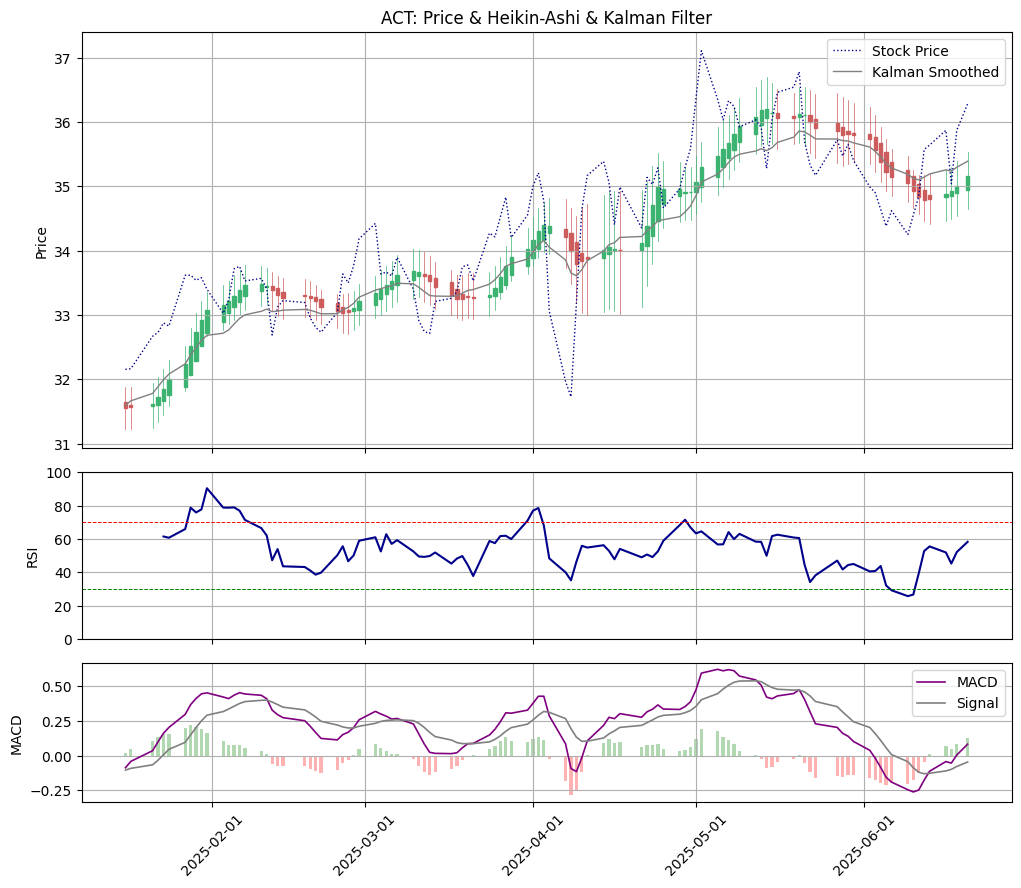

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


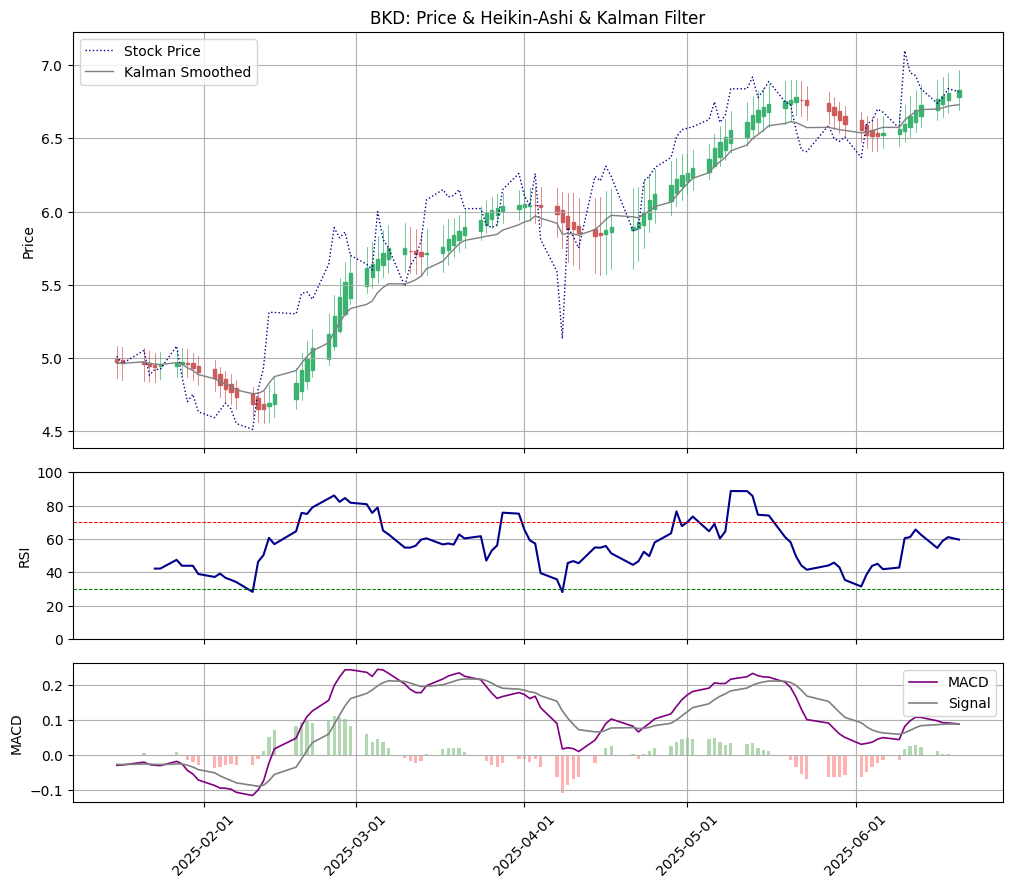

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


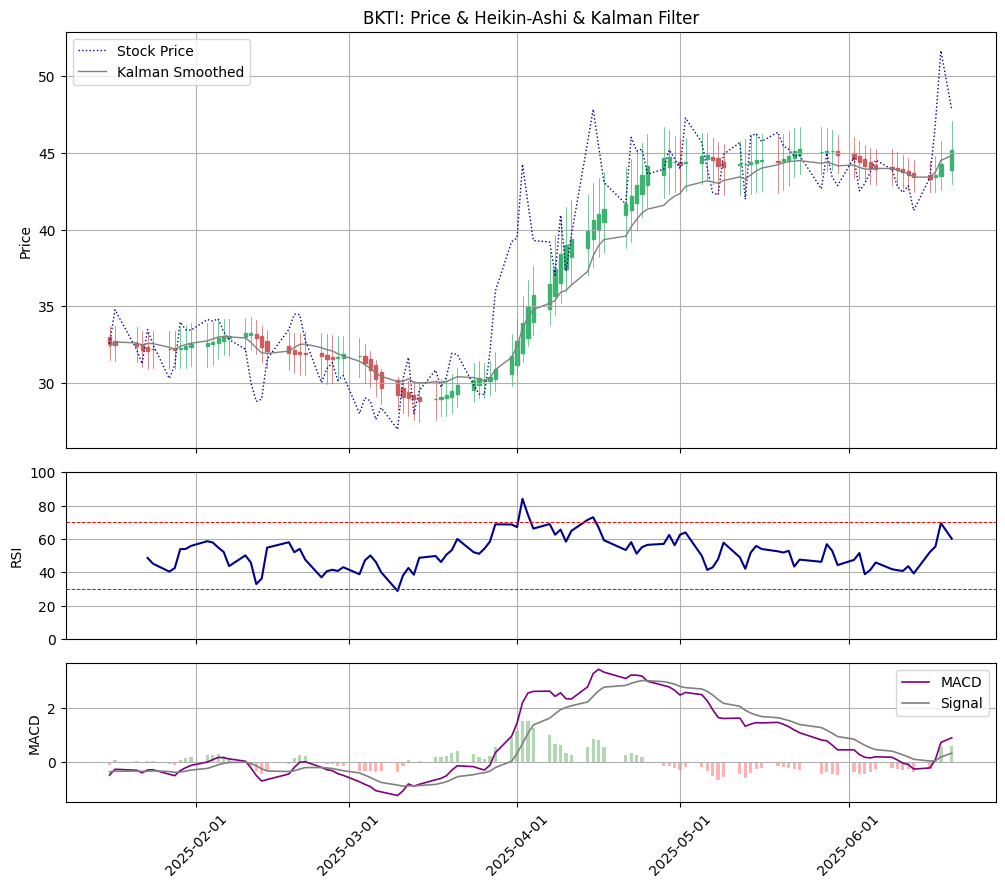

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


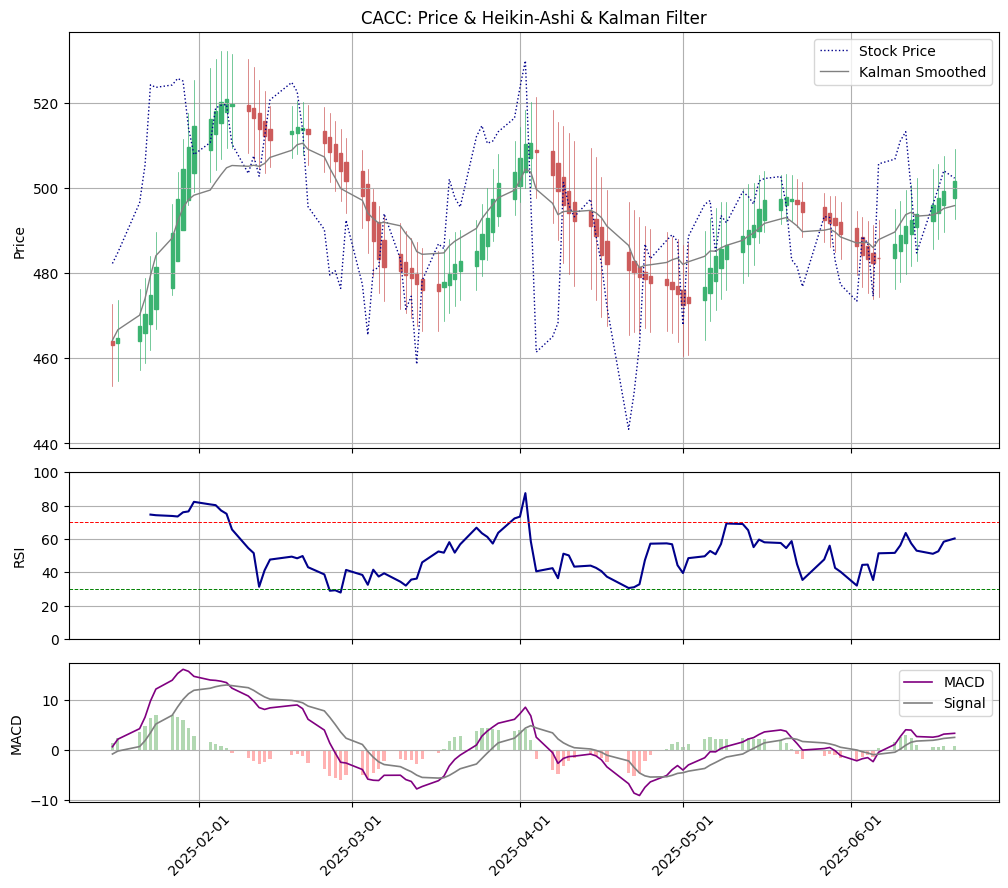

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


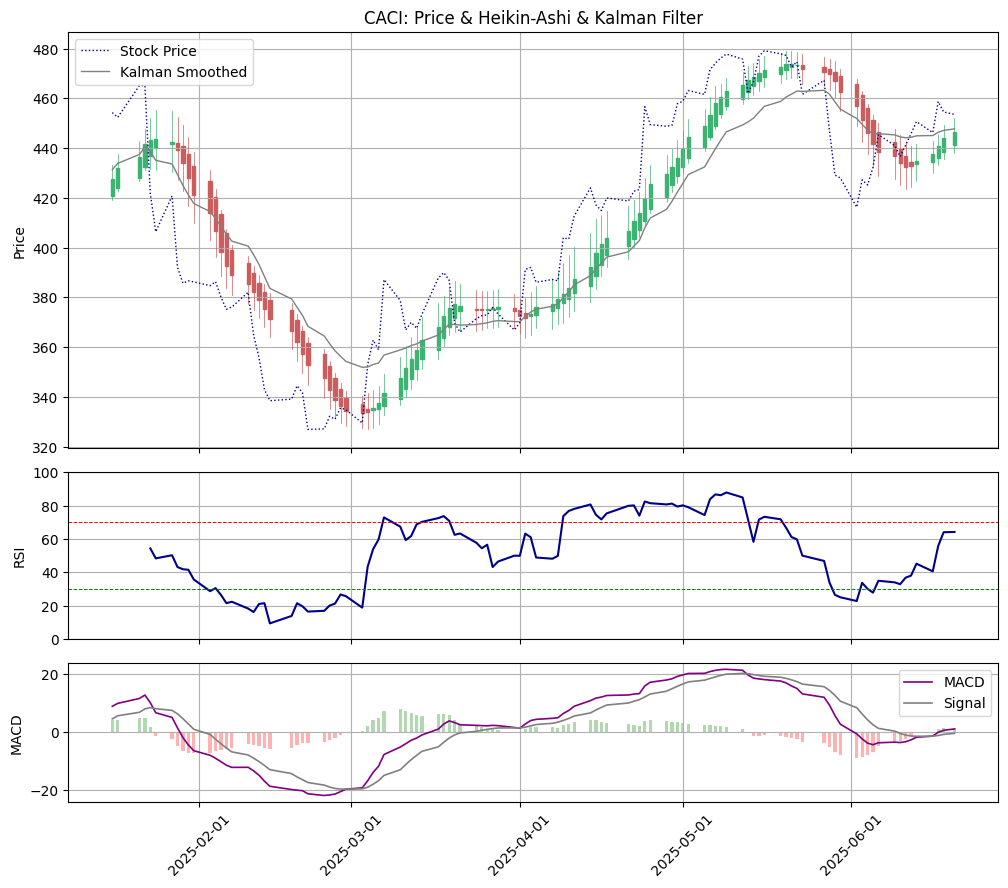

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


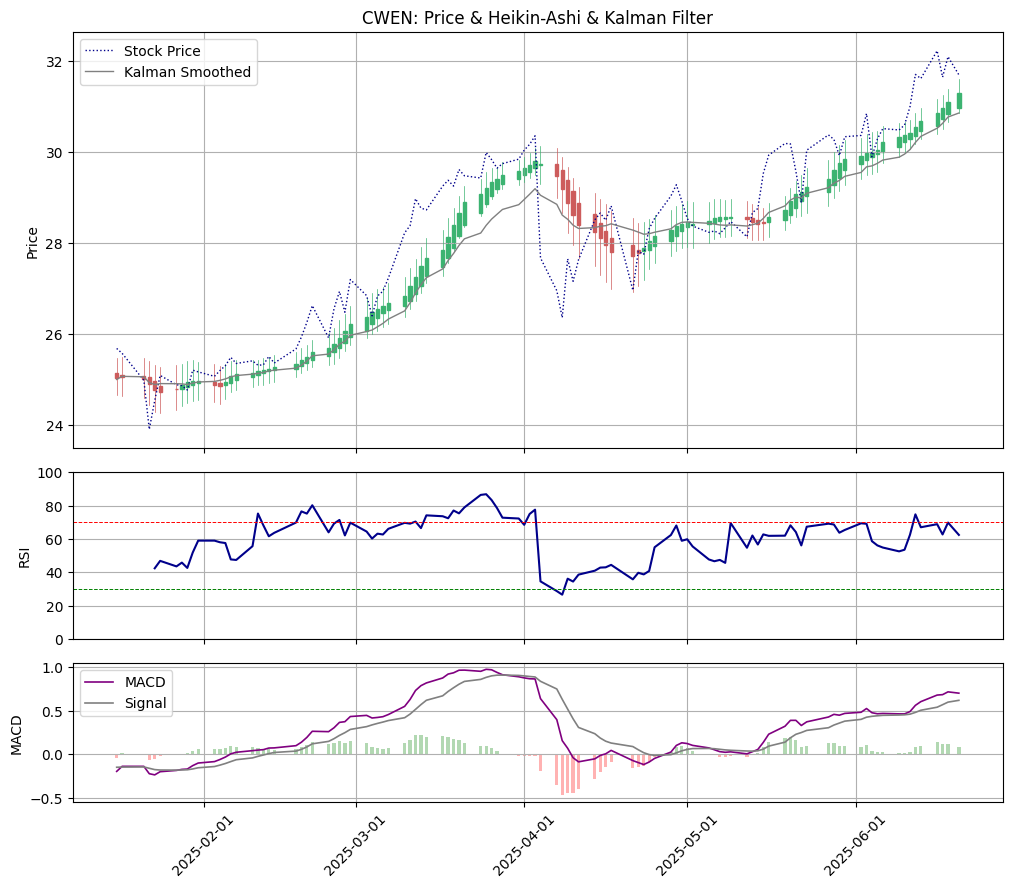

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


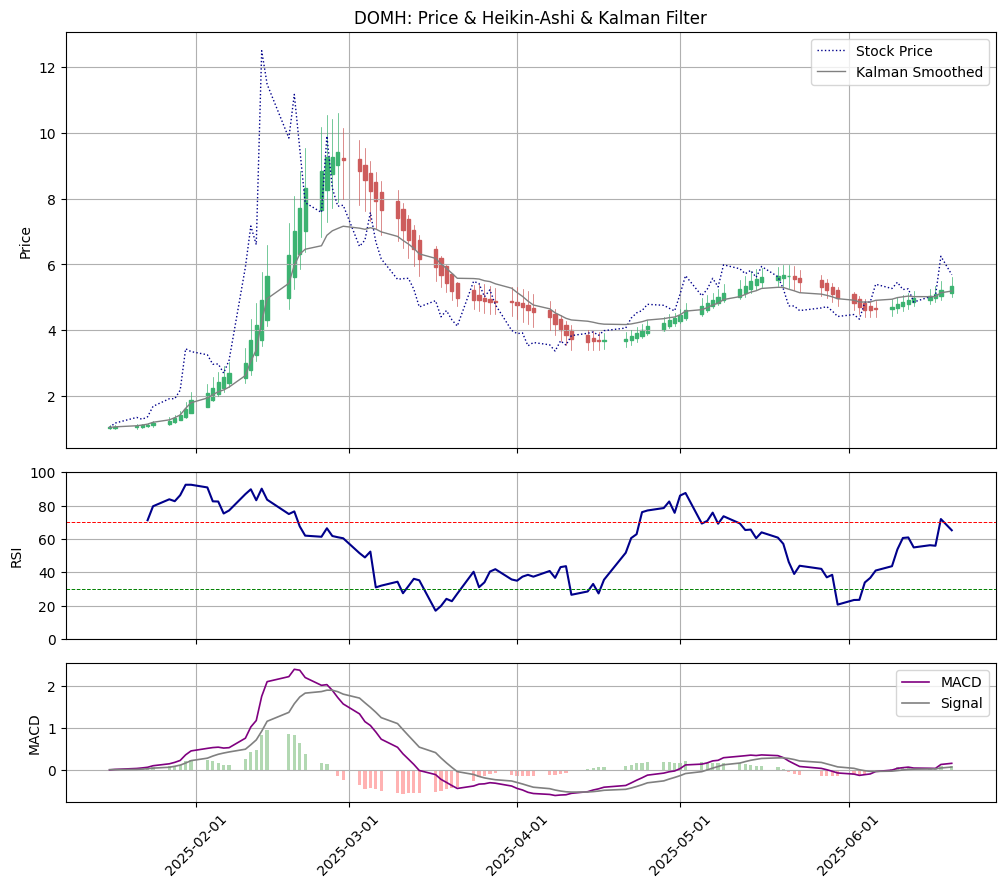

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


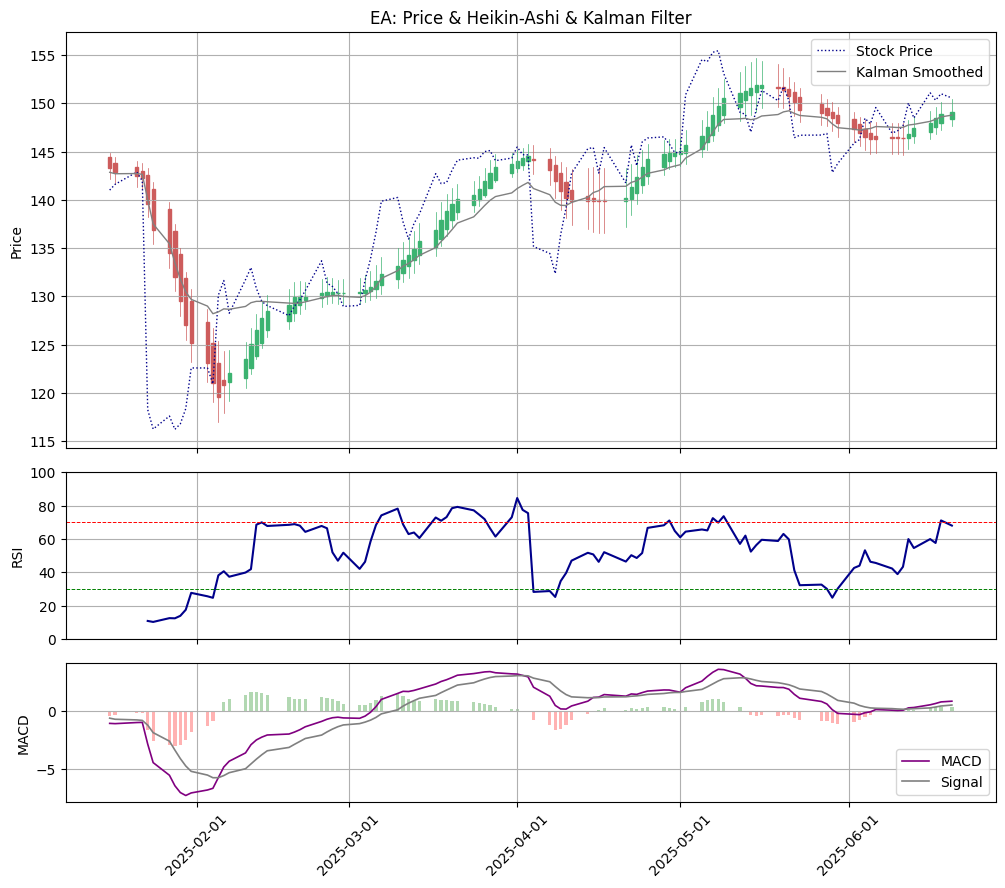

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


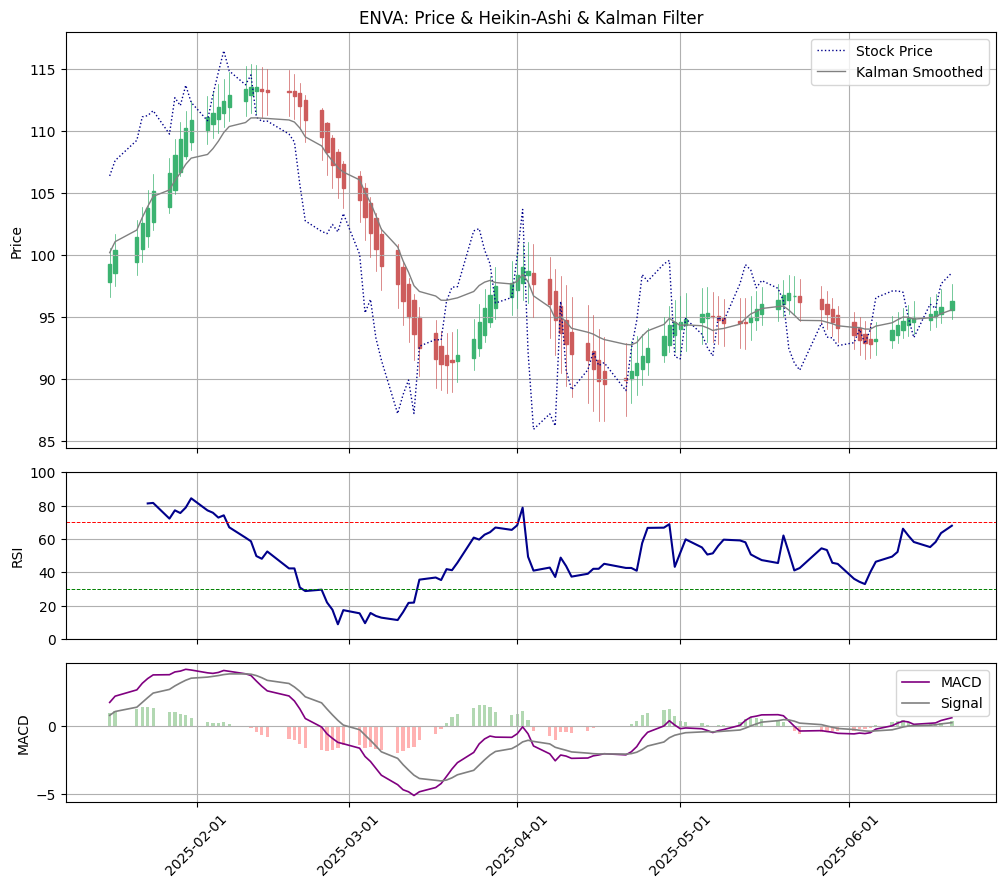

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


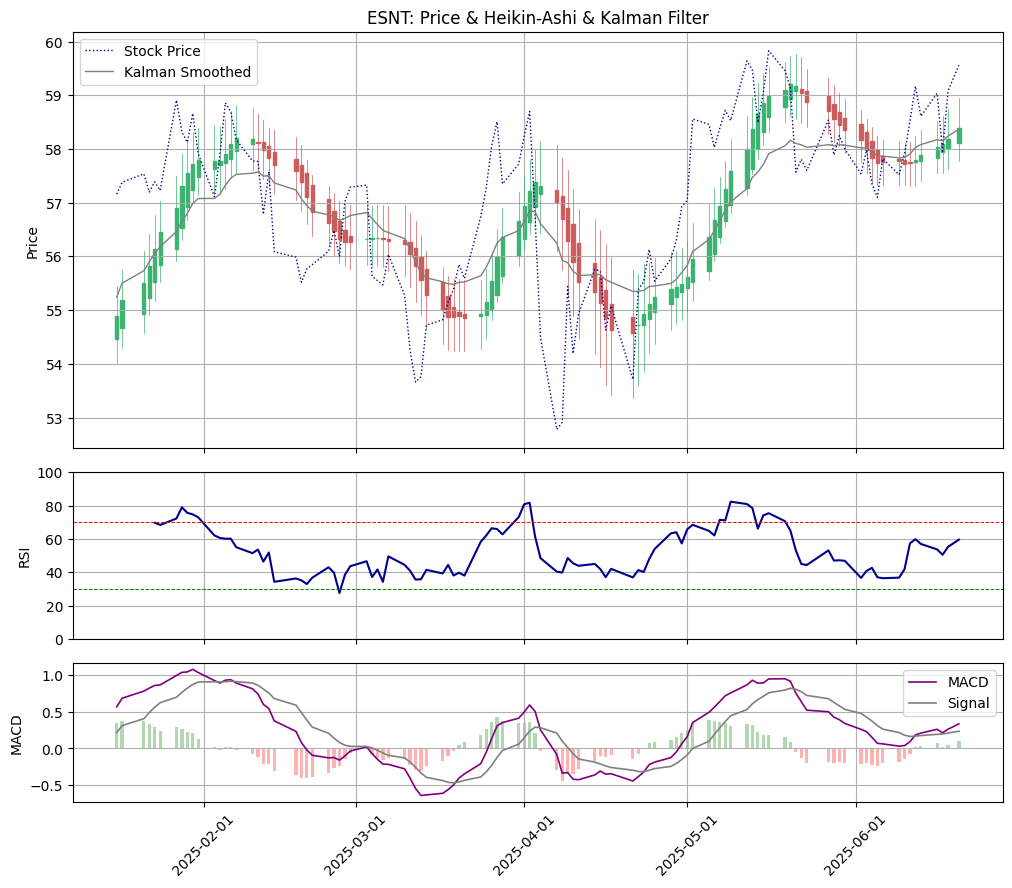

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


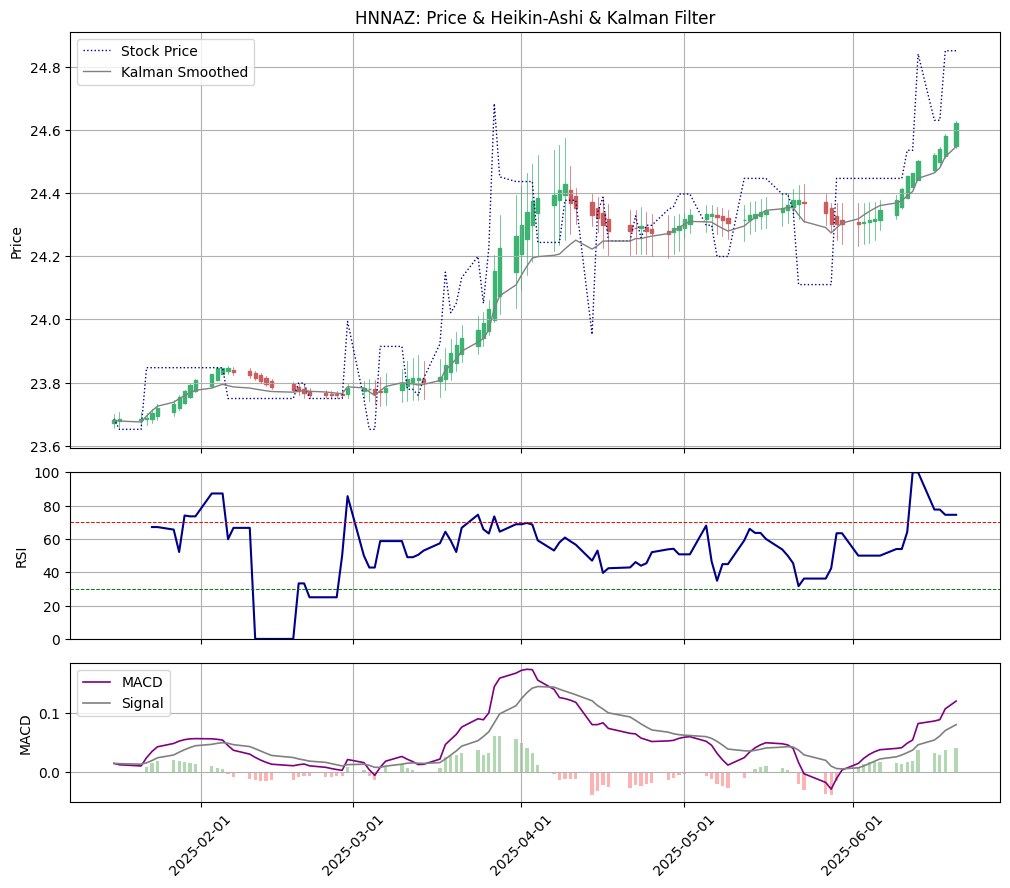

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


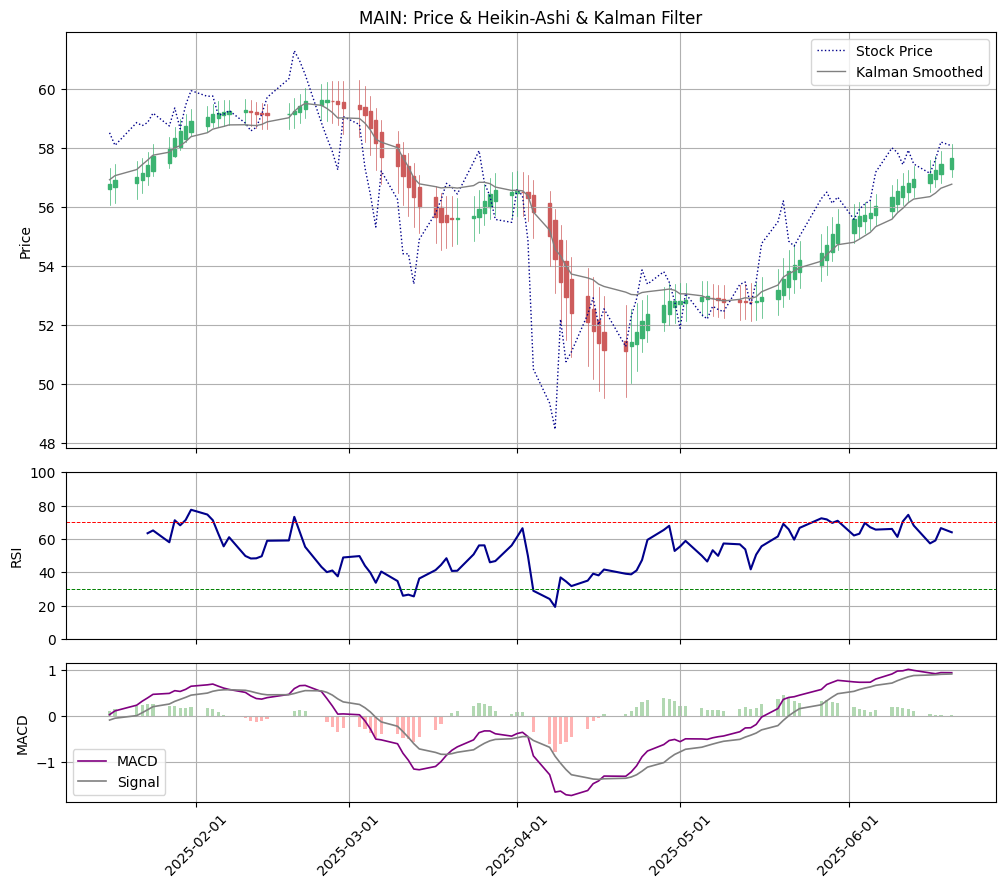

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


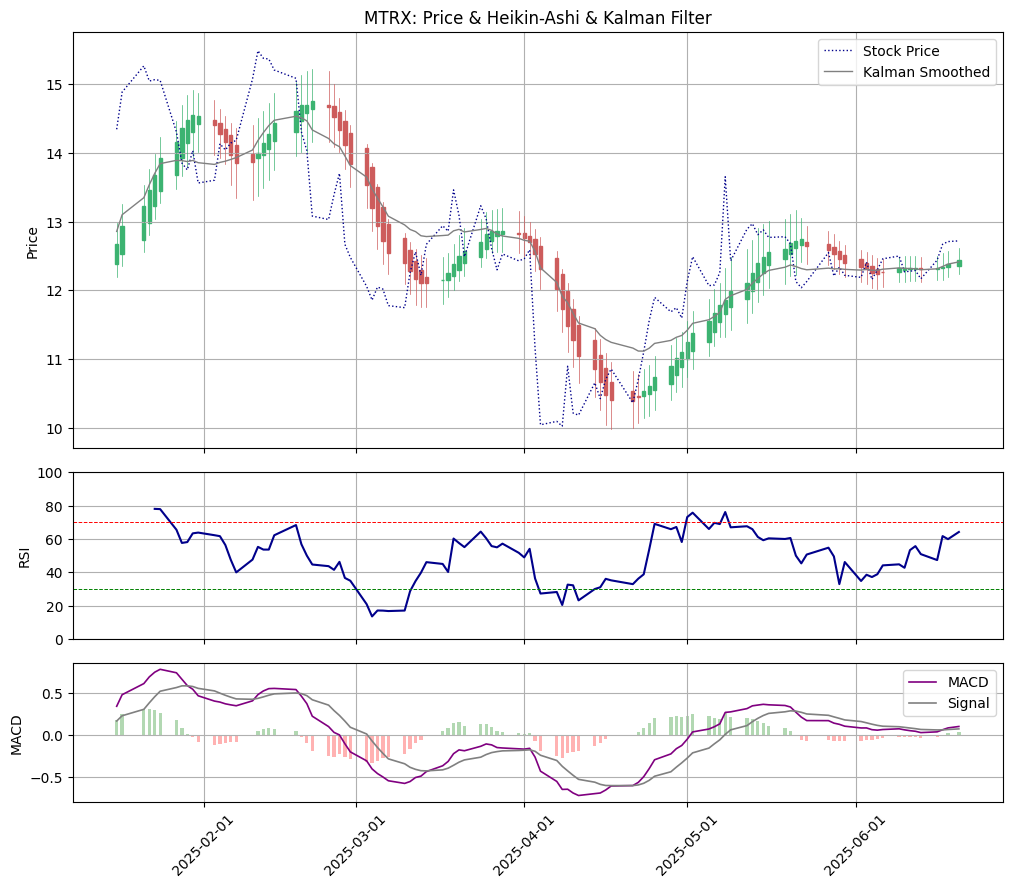

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


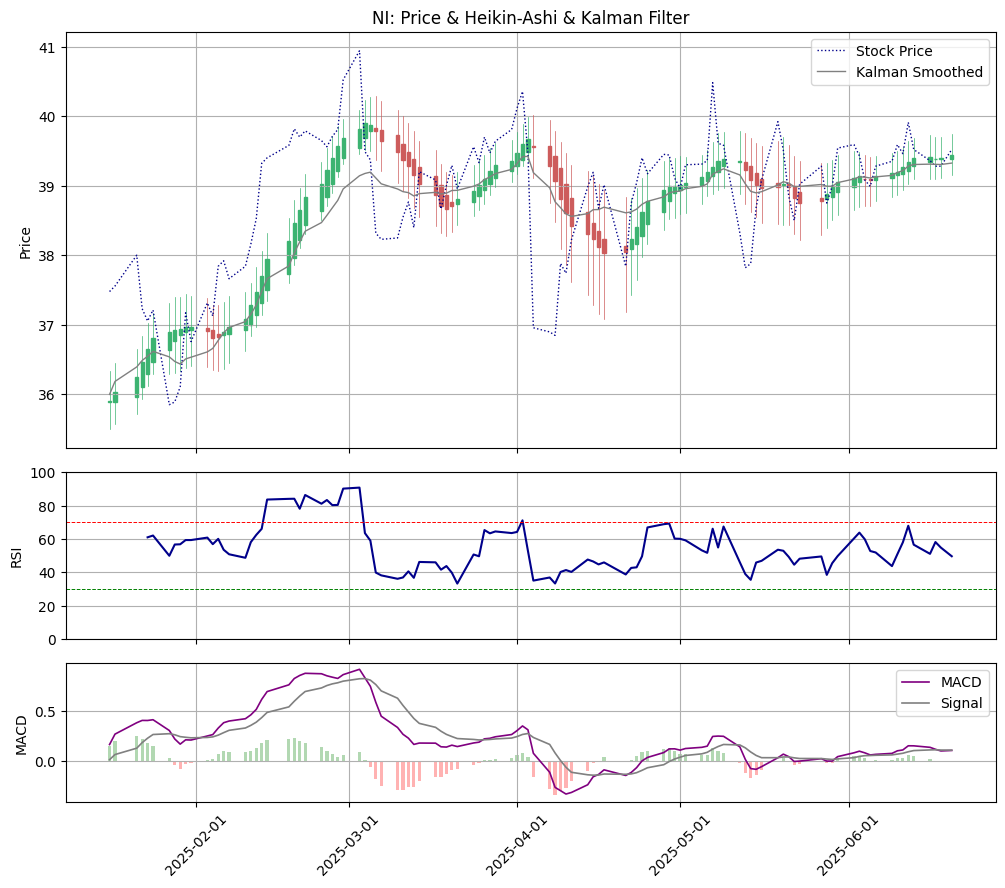

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


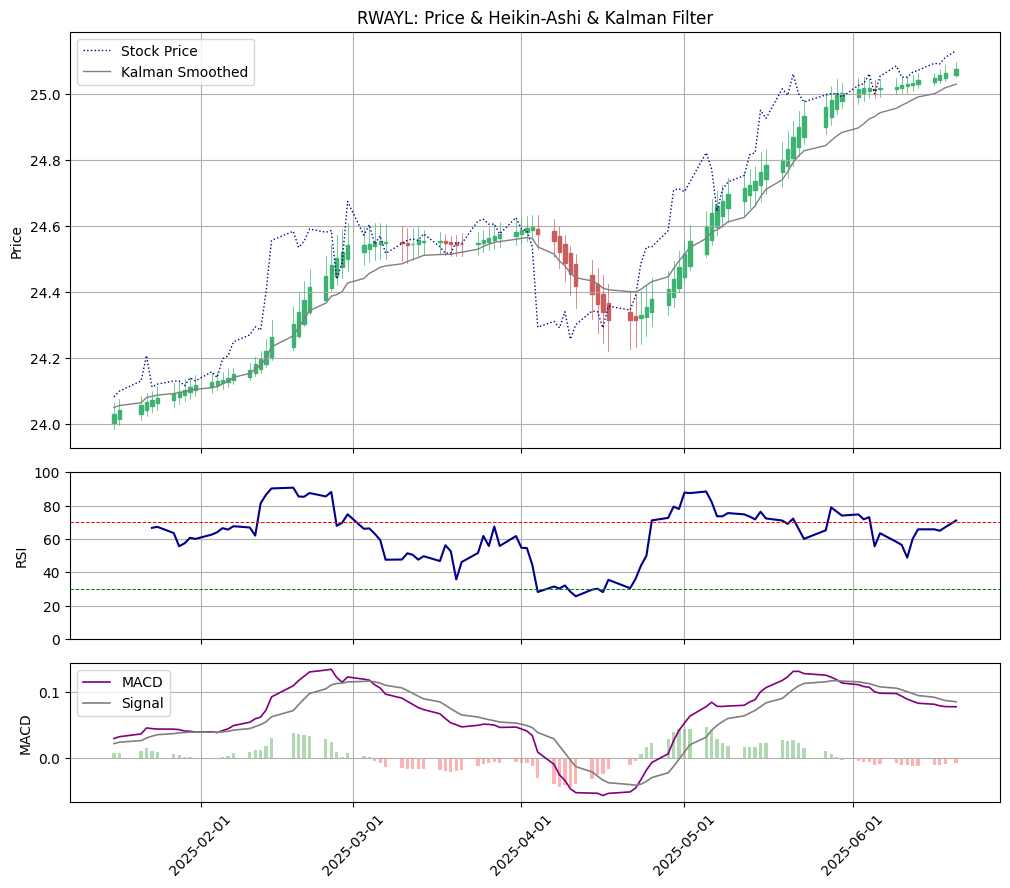

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


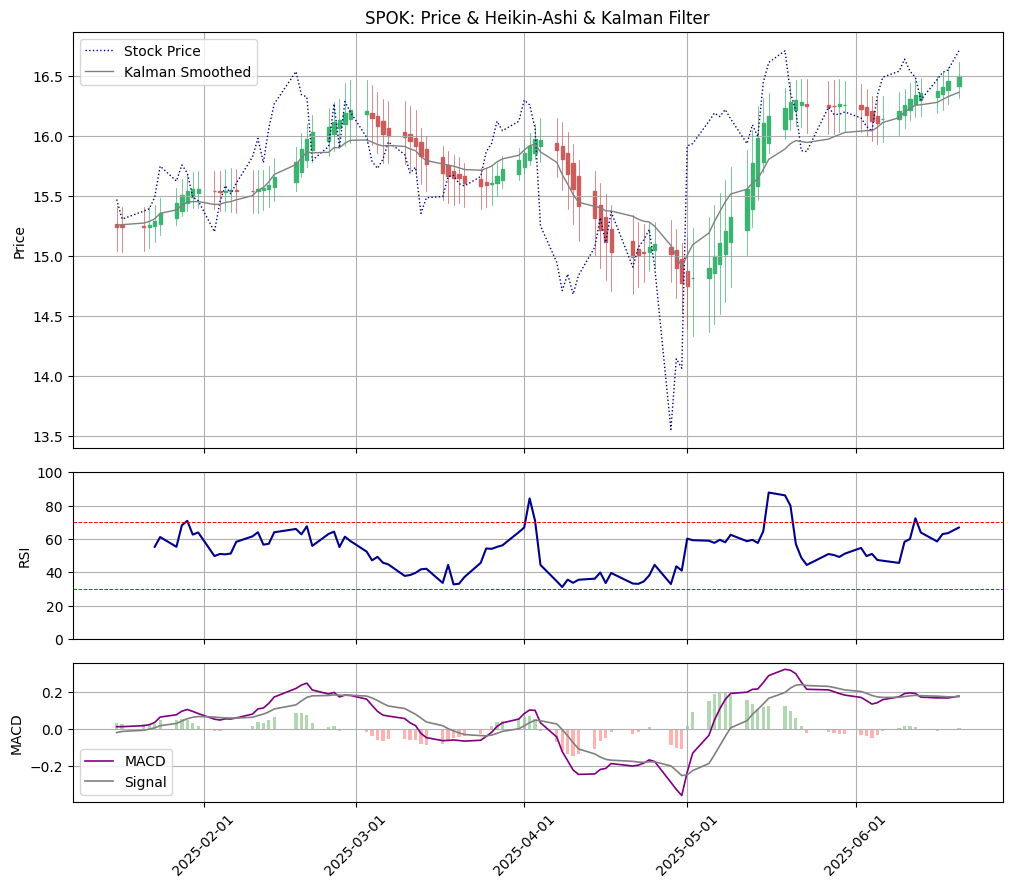

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


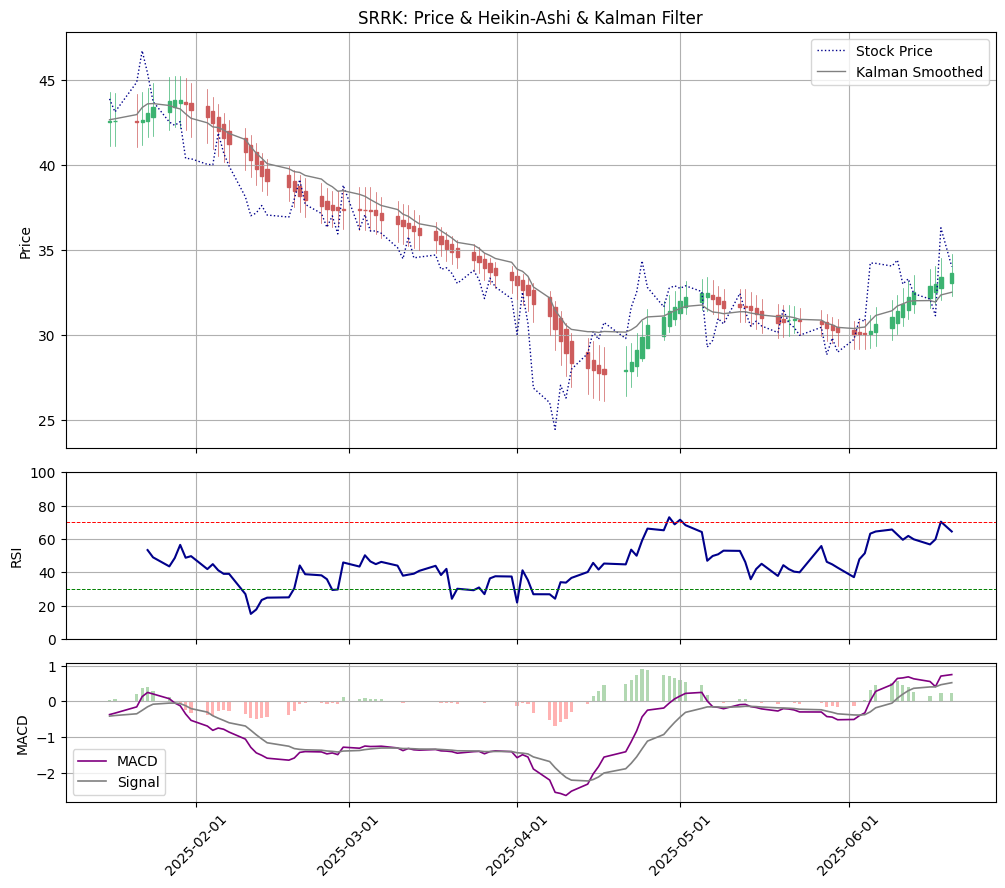

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


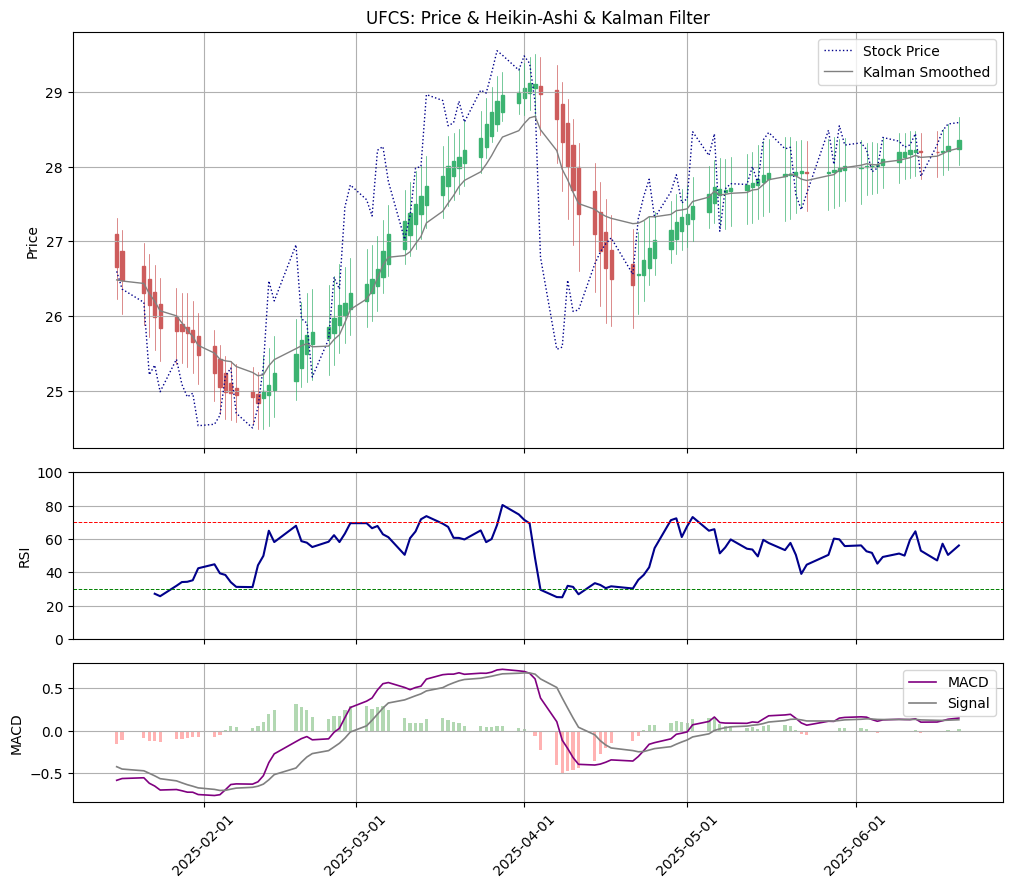

c:\Projekt\marketscreener\tools\calculations.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_17576\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


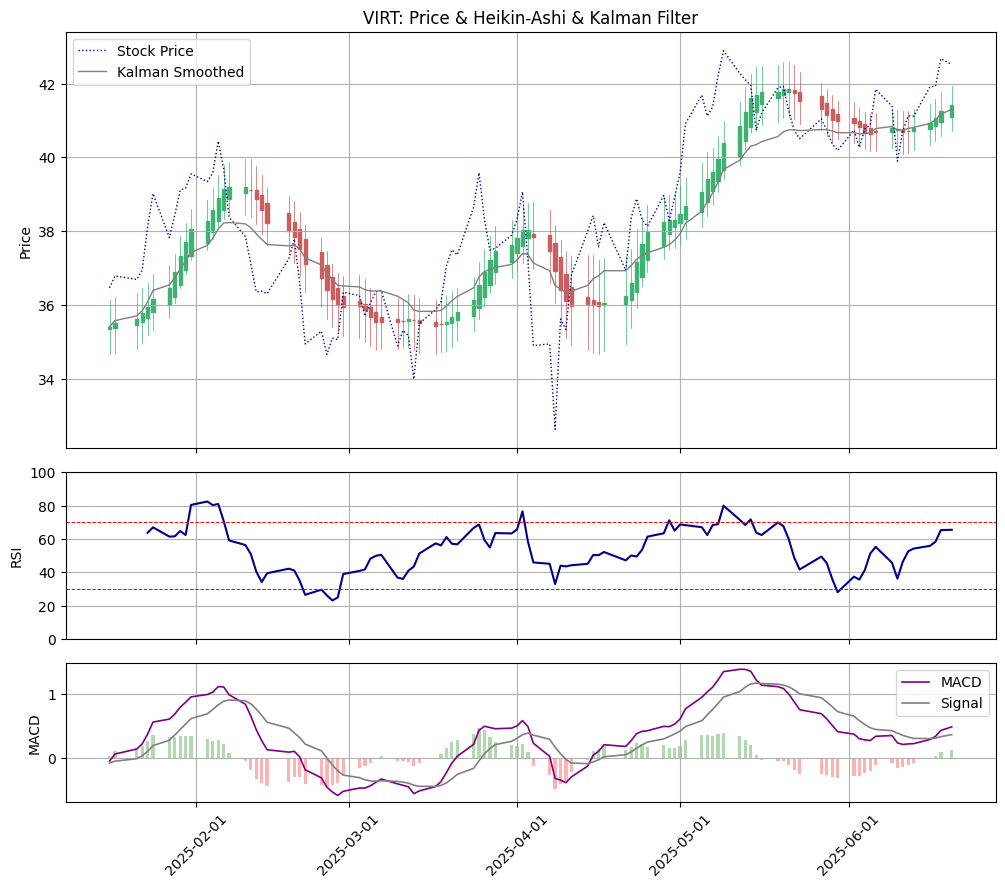

In [14]:
for ticker in close_prices.columns.tolist():
    smoothed = pd.Series(kalman_filter(close_prices[ticker]), index=close_prices[ticker].index)

    df_ticker = series.xs(ticker, axis=1, level=1).dropna()

    # Heikin-Ashi
    df_ha = heikin_ashi(df_ticker)
    df_ha.columns = ['Open', 'Close', 'High', 'Low', 'Volume']
    df_ha = df_ha[['Open', 'High', 'Low', 'Close', 'Volume']]

   # MACD and RSI
    macd_line, signal_line, hist = calculate_macd(close_prices[ticker])
    macd_line, signal_line, hist = calculate_macd(close_prices[ticker])
    macd_line = macd_line.loc[df_ha.index]       # optional
    signal_line = signal_line.loc[df_ha.index]   # optional
    hist = hist.loc[df_ha.index]                 # optional
    rsi = calculate_rsi(close_prices[ticker])
    rsi = rsi.loc[df_ha.index]  # Align RSI with HA chart

    # Prepare OHLC for plotting
    df_ha_ohlc = df_ha.copy()
    df_ha_ohlc['Date'] = mdates.date2num(df_ha_ohlc.index.to_pydatetime())
    df_ha_ohlc = df_ha_ohlc[['Date', 'Open', 'High', 'Low', 'Close']]
    quotes = [tuple(x) for x in df_ha_ohlc.values]
    dates = df_ha.index

    # Create figure with 3 panels: price, macd, rsi
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1.2, 1], hspace=0.1)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)

    # Plot Heikin-Ashi candles
    for quote in quotes:
        color = 'indianred' if quote[4] >= quote[1] else 'mediumseagreen'
        candlestick_ohlc(ax1, [quote], width=0.6, colorup=color, colordown=color)

    # Align with df_ha index
    aligned_close = close_prices[ticker].loc[df_ha.index]
    aligned_smoothed = smoothed.loc[df_ha.index]
    
    # Overlay close and Kalman-smoothed
    
    ax1.plot(dates, aligned_close, color='darkblue', label='Stock Price', linestyle=':', linewidth=1)
    ax1.plot(dates, aligned_smoothed, color='gray', label='Kalman Smoothed', linewidth=1)
    ax1.grid(which='minor', linestyle='-', linewidth=0.25)

    # ax1.plot(dates, close_prices[ticker], color='darkblue', label='Stock Price', linewidth=1)
    # ax1.plot(dates, smoothed, color='gray', label='Kalman Smoothed', linewidth=1)
    ax1.set_title(f"{ticker}: Price & Heikin-Ashi & Kalman Filter")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    # RSI Plot
    ax2.plot(dates, rsi, label='RSI', color='darkblue')
    ax2.axhline(70, color='red', linestyle='--', linewidth=0.7)
    ax2.axhline(30, color='green', linestyle='--', linewidth=0.7)
    ax2.set_ylabel("RSI")
    ax2.set_ylim(0, 100)
    ax2.grid(True)

    # MACD Plot
    ax3.plot(dates, macd_line, label='MACD', color='purple', linewidth=1.2)
    ax3.plot(dates, signal_line, label='Signal', color='gray', linewidth=1.2)
    ax3.bar(dates, hist, color=['green' if h >= 0 else 'red' for h in hist], width=0.6, alpha=0.3)
    ax3.set_ylabel("MACD")
    ax3.legend()
    ax3.grid(True)

    # Formatting x-axis
    ax3.xaxis_date()
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
